In [2]:
import os
print(os.getcwd())


c:\Users\haiye\OneDrive\Desktop\Nam3_Ki1\Machine_learning\BTL\mallorn-astronomical-classification-challenge


In [6]:
import os
import pandas as pd
import numpy as np

# =========================
# CẤU HÌNH (LOCAL)
# =========================

# ROOT dataset trên máy bạn
DATA_ROOT = r"C:\Users\haiye\OneDrive\Desktop\Nam3_Ki1\Machine_learning\BTL\mallorn-astronomical-classification-challenge"

# Thư mục output (tạo cùng thư mục notebook)
OUT_ROOT = "cleaned_lightcurves"

SPLITS = range(1, 21)

REQUIRED_COLS = ["object_id", "Time (MJD)", "Flux", "Flux_err", "Filter"]
VALID_FILTERS = {"u", "g", "r", "i", "z", "y"}

os.makedirs(OUT_ROOT, exist_ok=True)

# =========================
# HÀM CLEAN
# =========================
def clean_lightcurve_file(csv_path, is_test_set=False):
    if not os.path.exists(csv_path):
        print(f"!!! Warning: Không tìm thấy file {csv_path}")
        return pd.DataFrame(), 0, 0

    lc = pd.read_csv(csv_path)
    n_before = len(lc)

    original_ids = lc['object_id'].unique() if is_test_set else None

    # ---- 1. Lọc cơ bản ----
    mask = (
        lc[REQUIRED_COLS].notna().all(axis=1) &
        (lc["Flux_err"] > 0) &
        (lc["Filter"].isin(VALID_FILTERS))
    )

    lc_clean = lc[mask].copy()

    # ---- 2. GỘP TRÙNG (Weighted Average) ----
    lc_clean['w'] = 1.0 / (lc_clean['Flux_err'] ** 2)
    lc_clean['flux_w'] = lc_clean['Flux'] * lc_clean['w']

    group_cols = ["object_id", "Time (MJD)", "Filter"]

    lc_grouped = (
        lc_clean
        .groupby(group_cols)[['flux_w', 'w']]
        .sum()
        .reset_index()
    )

    lc_grouped['Flux'] = lc_grouped['flux_w'] / lc_grouped['w']
    lc_grouped['Flux_err'] = 1.0 / np.sqrt(lc_grouped['w'])

    lc_final = lc_grouped[REQUIRED_COLS].copy()

    # ---- 3. CỨU HỘ TEST ----
    if is_test_set:
        remaining_ids = set(lc_final['object_id'].unique())
        missing_ids = set(original_ids) - remaining_ids

        if missing_ids:
            print(f"   ⚠️ CỨU {len(missing_ids)} ID bị mất trong TEST")
            rescue_df = lc[lc['object_id'].isin(missing_ids)].copy()
            rescue_df['Flux'] = rescue_df['Flux'].fillna(0)
            rescue_df.loc[rescue_df['Flux_err'] <= 0, 'Flux_err'] = 1.0
            rescue_df = rescue_df[REQUIRED_COLS]

            lc_final = pd.concat([lc_final, rescue_df])

    # ---- 4. Sort ----
    lc_final = lc_final.sort_values(["object_id", "Time (MJD)"])

    n_after = len(lc_final)
    return lc_final, n_before, n_after

# =========================
# CHẠY LOOP
# =========================
print("===== START CLEANING (LOCAL MODE) =====")

for i in SPLITS:
    split_name = f"Split_{i:02d}"
    split_dir = os.path.join(DATA_ROOT, split_name)

    if not os.path.exists(split_dir):
        split_name = f"split_{i:02d}"
        split_dir = os.path.join(DATA_ROOT, split_name)

    if not os.path.exists(split_dir):
        print(f"❌ Không tìm thấy folder Split {i:02d}")
        continue

    for mode in ["train", "test"]:
        in_path = os.path.join(split_dir, f"{mode}_full_lightcurves.csv")

        lc_clean, n_before, n_after = clean_lightcurve_file(
            in_path,
            is_test_set=(mode == "test")
        )

        if not lc_clean.empty:
            out_name = f"split_{i:02d}_{mode}_clean.csv"
            out_path = os.path.join(OUT_ROOT, out_name)

            lc_clean.to_csv(out_path, index=False)

            print(
                f"Split {i:02d} | {mode.upper():5s} | "
                f"{n_before:7d} -> {n_after:7d} "
                f"(loại bỏ: {n_before - n_after})"
            )

print("===== CLEANING DONE =====")


===== START CLEANING (LOCAL MODE) =====
Split 01 | TRAIN |   26324 ->   26313 (loại bỏ: 11)
Split 01 | TEST  |   59235 ->   59212 (loại bỏ: 23)
Split 02 | TRAIN |   25609 ->   25603 (loại bỏ: 6)
Split 02 | TEST  |   71229 ->   71221 (loại bỏ: 8)
Split 03 | TRAIN |   21676 ->   21671 (loại bỏ: 5)
Split 03 | TEST  |   53751 ->   53743 (loại bỏ: 8)
Split 04 | TRAIN |   22898 ->   22886 (loại bỏ: 12)
Split 04 | TEST  |   51408 ->   51358 (loại bỏ: 50)
Split 05 | TRAIN |   25934 ->   25919 (loại bỏ: 15)
Split 05 | TEST  |   61179 ->   61137 (loại bỏ: 42)
Split 06 | TRAIN |   25684 ->   25673 (loại bỏ: 11)
Split 06 | TEST  |   57620 ->   57599 (loại bỏ: 21)
Split 07 | TRAIN |   24473 ->   24167 (loại bỏ: 306)
Split 07 | TEST  |   65101 ->   64197 (loại bỏ: 904)
Split 08 | TRAIN |   25571 ->   25565 (loại bỏ: 6)
Split 08 | TEST  |   61498 ->   61451 (loại bỏ: 47)
Split 09 | TRAIN |   19690 ->   19375 (loại bỏ: 315)
Split 09 | TEST  |   47239 ->   46725 (loại bỏ: 514)
Split 10 | TRAIN |   2515

In [10]:
# số điểm quan sát/ object

summary = []

count = 0

for i in range(1, 21):
    file_path = f"cleaned_lightcurves/split_{i:02d}_train_clean.csv"

    if not os.path.exists(file_path):
        continue

    lc = pd.read_csv(file_path)
    obs_per_object = lc.groupby("object_id").size()

    desc = obs_per_object.describe()
    count += desc["count"]
    desc["split"] = f"{i:02d}"
    
    summary.append(desc)

summary_df = pd.DataFrame(summary).set_index("split")
print("Count:", int(count))
summary_df


Count: 3043


,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
01,155.0,169.761290,150.107022,30.0,124.50,149.0,167.00,1081.0
02,170.0,150.605882,78.624740,41.0,126.00,148.0,168.75,1067.0
03,138.0,157.036232,111.847159,31.0,126.00,147.0,169.00,1092.0
04,145.0,157.834483,134.881379,33.0,113.00,141.0,163.00,1043.0
05,165.0,157.084848,99.941410,30.0,126.00,150.0,170.00,1077.0
06,155.0,165.632258,136.417713,50.0,122.00,150.0,165.00,1066.0
07,165.0,146.466667,42.577552,38.0,121.00,149.0,166.00,496.0
08,162.0,157.808642,123.661858,25.0,122.25,154.5,169.00,1162.0
09,128.0,151.367188,97.125203,15.0,115.75,151.0,167.25,1037.0


In [8]:


ALL_OBS = []

for i in range(1, 21):
    file_path = f"cleaned_lightcurves/split_{i:02d}_train_clean.csv"
    
    if not os.path.exists(file_path):
        print(f"❌ Missing: {file_path}")
        continue

    lc = pd.read_csv(file_path)
    
    obs_per_object = lc.groupby("object_id").size()
    
    # Gộp tất cả object của mọi split
    ALL_OBS.append(obs_per_object)

# Gộp thành 1 Series lớn
all_obs_per_object = pd.concat(ALL_OBS)

print("📊 THỐNG KÊ TỔNG THỂ 20 SPLITS")
print(all_obs_per_object.describe())


📊 THỐNG KÊ TỔNG THỂ 20 SPLITS
count    3043.000000
mean      157.243838
std       108.845953
min        15.000000
25%       124.000000
50%       150.000000
75%       167.500000
max      1162.000000
dtype: float64


EDA

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# CẤU HÌNH ĐƯỜNG DẪN (Bạn sửa lại nếu cần)
# Giả sử bạn đang chạy với file mẫu bạn đã upload
PATH_TRAIN_LOG = 'train_log.csv'
PATH_TEST_LOG = 'test_log.csv'
PATH_LC_SAMPLE = "cleaned_lightcurves/split_02_train_clean.csv" # Đây là 1 split mẫu để soi chi tiết

# 1. LOAD DATA
print(">>> Đang tải dữ liệu...")
train_log = pd.read_csv(PATH_TRAIN_LOG)
test_log = pd.read_csv(PATH_TEST_LOG)
lc_sample = pd.read_csv(PATH_LC_SAMPLE)

# Merge thông tin Target vào LC mẫu để tiện phân tích
# Chỉ lấy các cột cần thiết từ train_log mà chưa có trong lc_samp

lc_merged = lc_sample.merge(train_log[['object_id', 'target', 'SpecType', 'Z', 'EBV']], 
                            on='object_id', how='inner')


print(f"Data Loaded: {len(train_log)} logs, {len(lc_merged)} lightcurve points.")


>>> Đang tải dữ liệu...
Data Loaded: 3043 logs, 25603 lightcurve points.


In [53]:
lc_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25603 entries, 0 to 25602
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   object_id   25603 non-null  object 
 1   Time (MJD)  25603 non-null  float64
 2   Flux        25603 non-null  float64
 3   Flux_err    25603 non-null  float64
 4   Filter      25603 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1000.2+ KB


In [55]:
lc_sample

,object_id,Time (MJD),Flux,Flux_err,Filter
0,Druadan_rodwen_bragol,62840.1965,-0.397599,0.506177,z
1,Druadan_rodwen_bragol,62842.6001,0.245953,0.354346,i
2,Druadan_rodwen_bragol,62842.6001,0.652025,0.723061,z
3,Druadan_rodwen_bragol,62845.0036,-0.390700,0.553018,i
4,Druadan_rodwen_bragol,62845.0036,-0.552347,0.502889,z
...,...,...,...,...,...
25598,tirith_amath_mil,64555.1242,1.058852,0.460086,z
25599,tirith_amath_mil,64557.2326,1.358480,0.457149,i
25600,tirith_amath_mil,64557.2326,1.716063,0.563972,z
25601,tirith_amath_mil,64582.5332,3.990103,1.907224,y


In [56]:
lc_sample["Filter"].value_counts()


Filter
i    5956
r    5942
z    5324
y    3750
g    2493
u    2138
Name: count, dtype: int64

In [57]:
train_log["target"].value_counts()
train_log["target"].value_counts(normalize=True)


target
0    0.951364
1    0.048636
Name: proportion, dtype: float64


=== 2.1 TARGET DISTRIBUTION ===
Non-TDE (0): 2895
TDE (1):     148
Tỷ lệ TDE:   0.0511 (1 TDE : 19 Non-TDE)


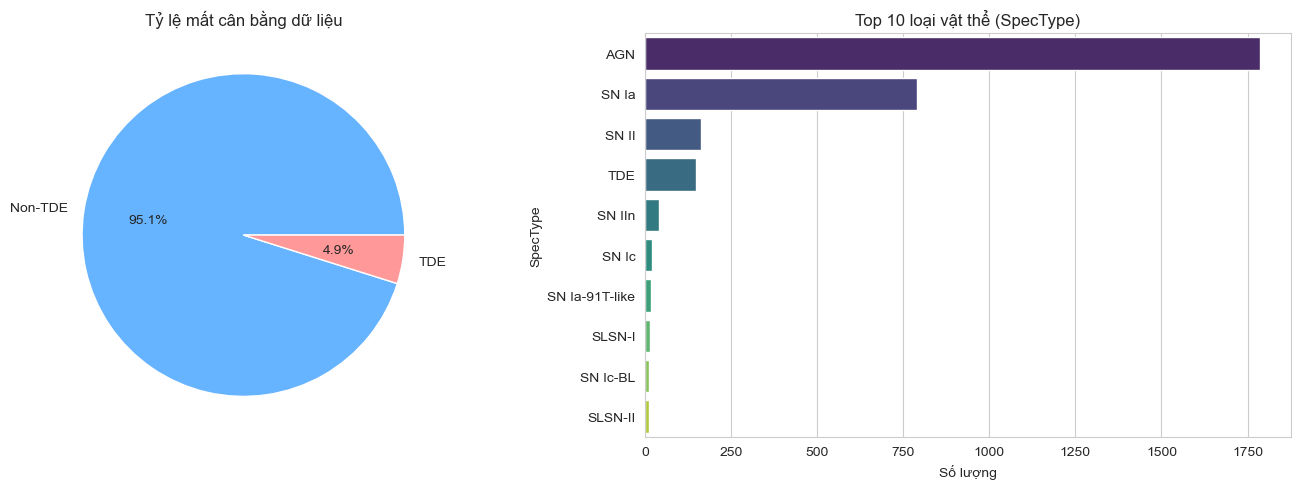

In [58]:
# --- 2.1 KIỂM TRA MẤT CÂN BẰNG ---
print("\n=== 2.1 TARGET DISTRIBUTION ===")
target_counts = train_log['target'].value_counts()
ratio = target_counts[1] / target_counts[0]
print(f"Non-TDE (0): {target_counts[0]}")
print(f"TDE (1):     {target_counts[1]}")
print(f"Tỷ lệ TDE:   {ratio:.4f} (1 TDE : {int(1/ratio)} Non-TDE)")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ tròn tỷ lệ
ax[0].pie(target_counts, labels=['Non-TDE', 'TDE'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
ax[0].set_title('Tỷ lệ mất cân bằng dữ liệu')

# Phân bố các loại vật thể (Kẻ thù là ai?)
# Chỉ lấy Top 10 loại phổ biến nhất
top_types = train_log['SpecType'].value_counts().head(10)
sns.barplot(x=top_types.values, y=top_types.index, ax=ax[1], palette='viridis')
ax[1].set_title('Top 10 loại vật thể (SpecType)')
ax[1].set_xlabel('Số lượng')

plt.tight_layout()
plt.show()


=== 2.2 DISTRIBUTION CHECK (TRAIN vs TEST) ===


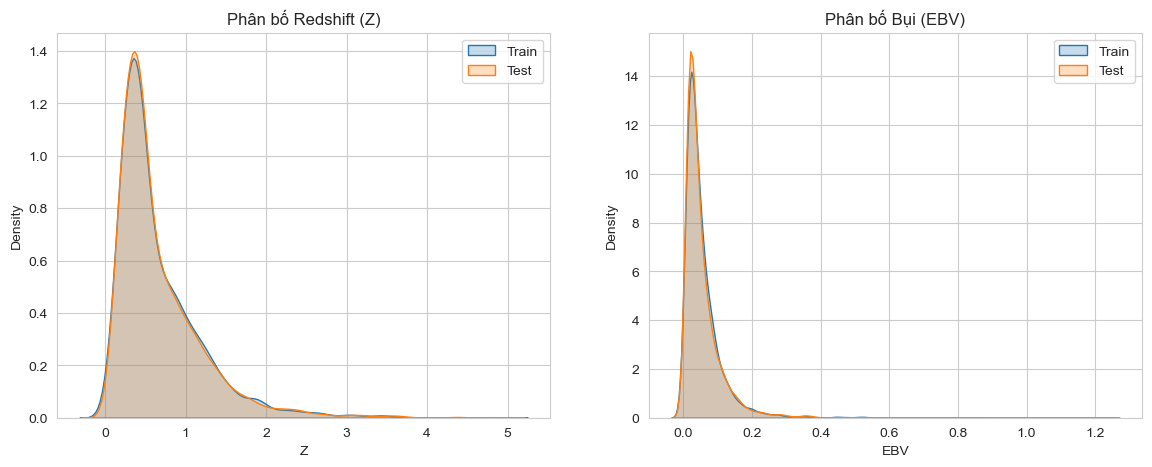

In [59]:
# --- 2.2 SO SÁNH TRAIN vs TEST (Z & EBV) ---
print("\n=== 2.2 DISTRIBUTION CHECK (TRAIN vs TEST) ===")
# Mục đích: Đảm bảo tập Train đại diện tốt cho tập Test
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=train_log, x='Z', label='Train', fill=True, ax=ax[0])
sns.kdeplot(data=test_log, x='Z', label='Test', fill=True, ax=ax[0])
ax[0].set_title('Phân bố Redshift (Z)')
ax[0].legend()

sns.kdeplot(data=train_log, x='EBV', label='Train', fill=True, ax=ax[1])
sns.kdeplot(data=test_log, x='EBV', label='Test', fill=True, ax=ax[1])
ax[1].set_title('Phân bố Bụi (EBV)')
ax[1].legend()

plt.show()

In [60]:
print("\n=== 3. STATISTICAL HYPOTHESIS TESTING ===")

def run_test(col):
    # Tách 2 nhóm
    tde = train_log[train_log['target'] == 1][col].dropna()
    non_tde = train_log[train_log['target'] == 0][col].dropna()
    
    # Kiểm định Mann-Whitney U (Không giả định phân phối chuẩn)
    stat, p_val = mannwhitneyu(tde, non_tde)
    
    print(f"Biến: {col}")
    print(f"  - Mean TDE: {tde.mean():.4f} | Mean Non-TDE: {non_tde.mean():.4f}")
    print(f"  - P-value:  {p_val:.4e}")
    if p_val < 0.05:
        print("  => KẾT LUẬN: Có sự khác biệt có ý nghĩa thống kê (Feature Tốt).")
    else:
        print("  => KẾT LUẬN: Không có sự khác biệt rõ rệt.")

run_test('Z')
run_test('EBV')


=== 3. STATISTICAL HYPOTHESIS TESTING ===
Biến: Z
  - Mean TDE: 0.5565 | Mean Non-TDE: 0.6765
  - P-value:  2.9148e-02
  => KẾT LUẬN: Có sự khác biệt có ý nghĩa thống kê (Feature Tốt).
Biến: EBV
  - Mean TDE: 0.0509 | Mean Non-TDE: 0.0558
  - P-value:  9.3505e-01
  => KẾT LUẬN: Không có sự khác biệt rõ rệt.


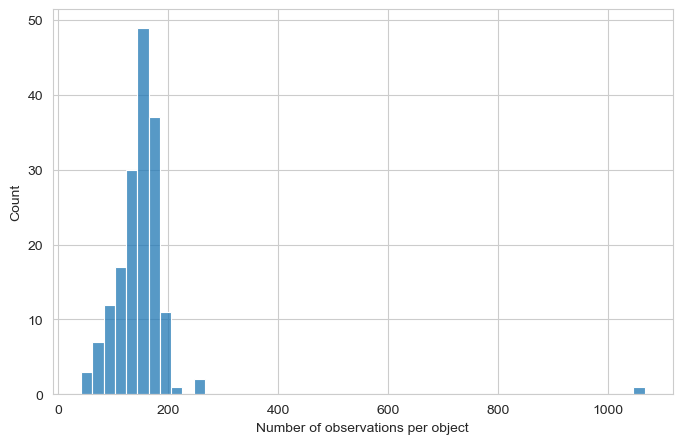

In [61]:
obs_per_obj = lc_sample.groupby("object_id").size()
obs_per_obj.describe()
plt.figure(figsize=(8,5))
sns.histplot(obs_per_obj, bins=50)
plt.xlabel("Number of observations per object")
plt.show()

In [64]:
bands_per_obj = lc_sample.groupby("object_id")["Filter"].nunique()
bands_per_obj.value_counts()
obj_4bands = bands_per_obj[bands_per_obj == 4].index
print(obj_4bands)

Index(['gorn_lebenedh_bregedur'], dtype='object', name='object_id')


In [66]:
lc_4bands = lc_sample[lc_sample["object_id"].isin(obj_4bands)]
missing_band_info = (
    lc_4bands.groupby("object_id")["Filter"]
    .apply(lambda x: sorted(set(["u","g","r","i","z","y"]) - set(x)))
)

missing_band_info

object_id
gorn_lebenedh_bregedur    [u, y]
Name: Filter, dtype: object


=== 4. LIGHTCURVE INSPECTION ===


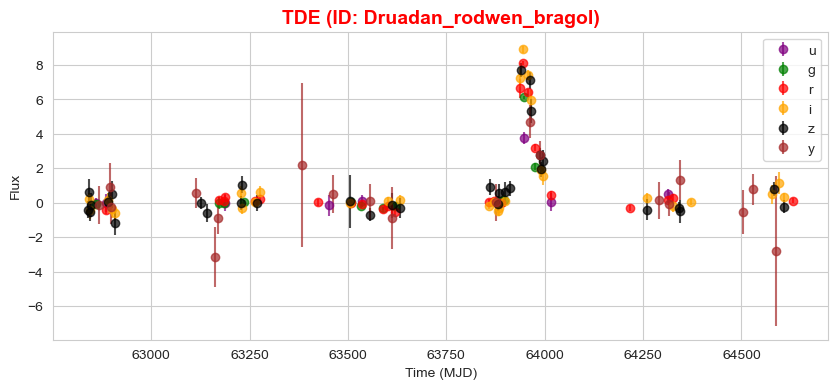

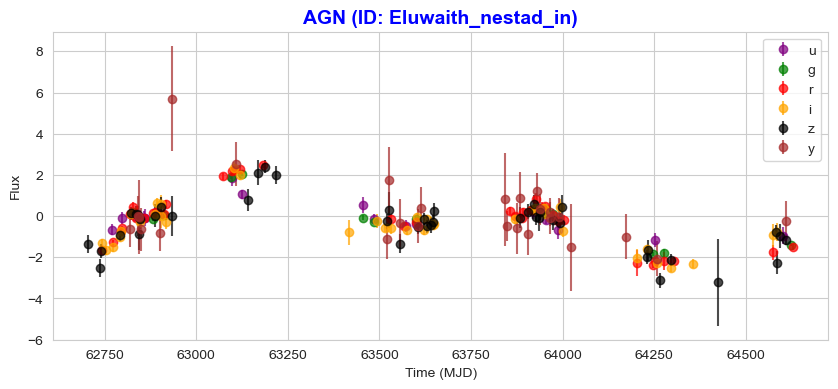

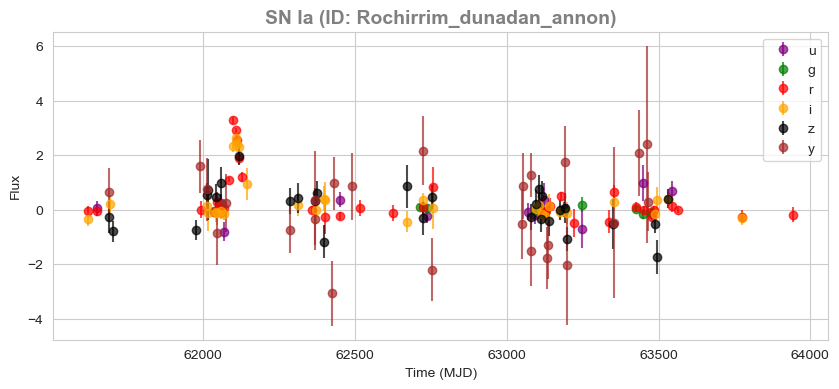

In [67]:
print("\n=== 4. LIGHTCURVE INSPECTION ===")

def plot_random_object(spec_type, title_color):
    # Lấy ngẫu nhiên 1 object thuộc loại này
    ids = lc_merged[lc_merged['SpecType'] == spec_type]['object_id'].unique()
    if len(ids) == 0: return
    
    oid = ids[0] # Lấy mẫu đầu tiên
    df = lc_merged[lc_merged['object_id'] == oid]
    
    plt.figure(figsize=(10, 4))
    # Định màu chuẩn thiên văn
    colors = {'u': 'purple', 'g': 'green', 'r': 'red', 'i': 'orange', 'z': 'black', 'y': 'brown'}
    
    for f in ['u', 'g', 'r', 'i', 'z', 'y']:
        subset = df[df['Filter'] == f]
        if len(subset) > 0:
            plt.errorbar(subset['Time (MJD)'], subset['Flux'], yerr=subset['Flux_err'], 
                         fmt='o', label=f, color=colors.get(f), alpha=0.7)
            
    plt.title(f'{spec_type} (ID: {oid})', color=title_color, fontsize=14, fontweight='bold')
    plt.xlabel('Time (MJD)')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()

# Vẽ 3 loại điển hình
plot_random_object('TDE', 'red')    # Mục tiêu
plot_random_object('AGN', 'blue')   # Nhiễu chính 1
plot_random_object('SN Ia', 'gray') # Nhiễu chính 2

In [72]:
lc_sample["SNR"] = lc_sample["Flux"] / lc_sample["Flux_err"]
lc_sample["SNR"].describe()

count    25603.000000
mean         2.612807
std          8.372909
min        -59.062100
25%         -0.424550
50%          0.735688
75%          2.913584
max        256.616326
Name: SNR, dtype: float64

In [73]:
lc_sample.groupby("Filter")["SNR"].describe()

,count,mean,std,min,25%,50%,75%,max
Filter,,,,,,,,
g,2493.0,5.171079,15.351841,-59.062100,-0.452913,1.098479,5.549046,256.616326
i,5956.0,2.679323,7.034608,-33.464876,-0.409967,0.908856,3.684030,101.341918
r,5942.0,4.199140,10.866327,-54.695334,-0.392898,1.246717,5.439246,125.170758
u,2138.0,1.320298,5.158338,-26.771004,-0.412779,0.432326,1.567309,85.198359
y,3750.0,0.619822,1.932098,-6.016345,-0.430395,0.379530,1.335884,26.908820
z,5324.0,1.492811,3.973675,-16.028105,-0.460206,0.633696,2.266841,41.276341


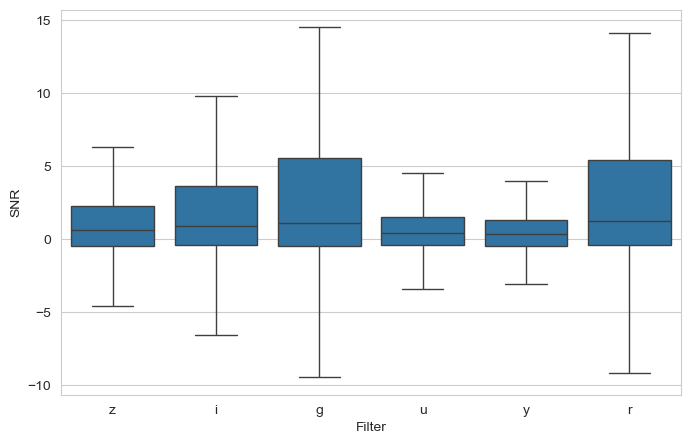

In [74]:
plt.figure(figsize=(8,5))
sns.boxplot(data=lc_sample, x="Filter", y="SNR", showfliers=False)
plt.show()


In [75]:
if "t_peak" in lc_sample.columns:
    lc_sample = lc_sample.drop(columns=["t_peak"])

lc_sample = lc_sample.join(
    t_peak.rename("t_peak"),
    on="object_id"
)

lc_sample["t_rel"] = lc_sample["Time (MJD)"] - lc_sample["t_peak"]


In [76]:
def duration(df):
    det = df[df["SNR"] > 3]
    if len(det) < 2:
        return 0
    return det["t_rel"].max() - det["t_rel"].min()

dur = lc_sample.groupby("object_id").apply(duration)

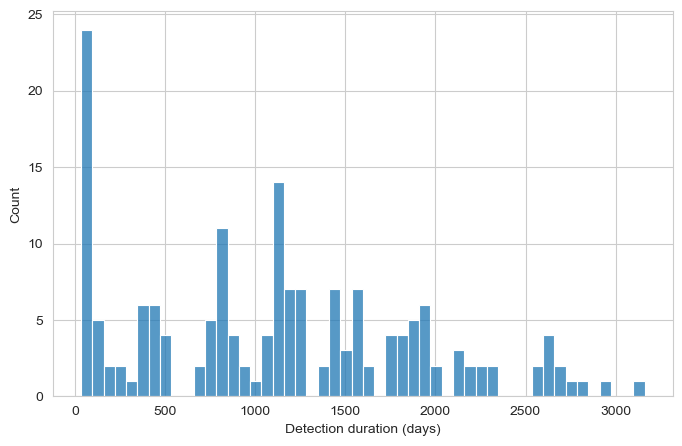

In [77]:
plt.figure(figsize=(8,5))
sns.histplot(dur, bins=50)
plt.xlabel("Detection duration (days)")
plt.show()



=== 5. FEATURE FEASIBILITY (COLOR ANALYSIS) ===


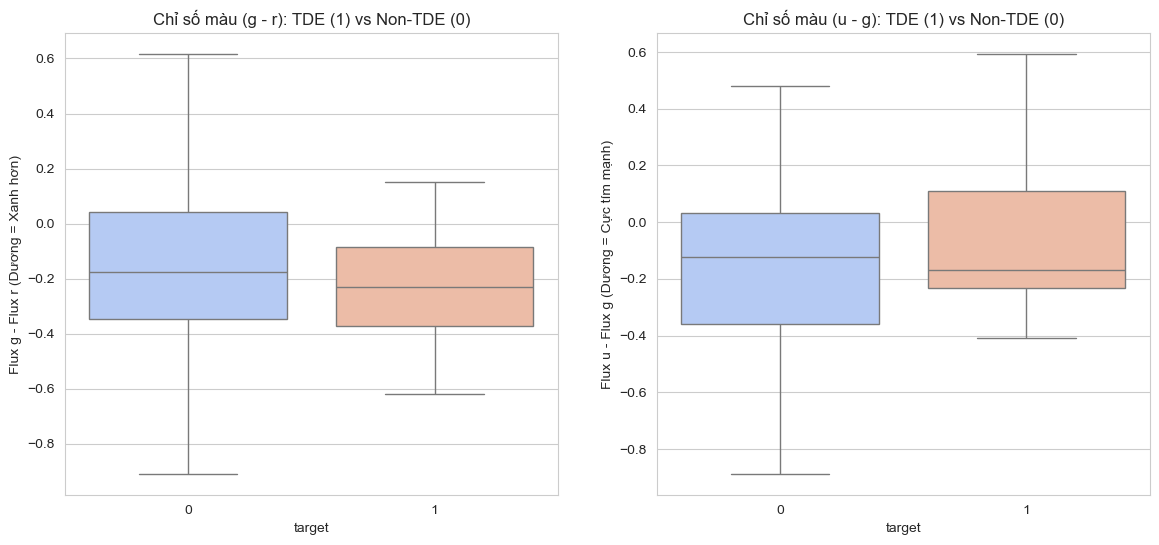

In [78]:
print("\n=== 5. FEATURE FEASIBILITY (COLOR ANALYSIS) ===")

# 1. Pivot dữ liệu mẫu để có cột Flux cho từng filter
pivot_lc = lc_merged.pivot_table(index=['object_id', 'target', 'SpecType'], 
                                 columns='Filter', values='Flux', aggfunc='mean').reset_index()

# 2. Tính chỉ số màu (Color Index)
# Lưu ý: Đây là hiệu Flux, thực tế dùng Magnitude sẽ chuẩn hơn nhưng Flux cũng thể hiện được xu hướng
if 'g' in pivot_lc.columns and 'r' in pivot_lc.columns:
    pivot_lc['g_minus_r'] = pivot_lc['g'] - pivot_lc['r']

if 'u' in pivot_lc.columns and 'g' in pivot_lc.columns:
    pivot_lc['u_minus_g'] = pivot_lc['u'] - pivot_lc['g']

# 3. Vẽ Boxplot so sánh
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Màu g - r
sns.boxplot(x='target', y='g_minus_r', data=pivot_lc, showfliers=False, ax=ax[0], palette='coolwarm')
ax[0].set_title('Chỉ số màu (g - r): TDE (1) vs Non-TDE (0)')
ax[0].set_ylabel('Flux g - Flux r (Dương = Xanh hơn)')

# Màu u - g
sns.boxplot(x='target', y='u_minus_g', data=pivot_lc, showfliers=False, ax=ax[1], palette='coolwarm')
ax[1].set_title('Chỉ số màu (u - g): TDE (1) vs Non-TDE (0)')
ax[1].set_ylabel('Flux u - Flux g (Dương = Cực tím mạnh)')

plt.show()


=== 6. DATA QUALITY CHECK (COVERAGE) ===
Trung bình số điểm ảnh (Observations) mỗi Filter:
Filter          g          i          r          u          y          z
target                                                                  
0       14.784810  34.892405  34.955696  12.708861  21.993671  31.183544
1       13.083333  36.916667  34.916667  10.833333  22.916667  33.083333


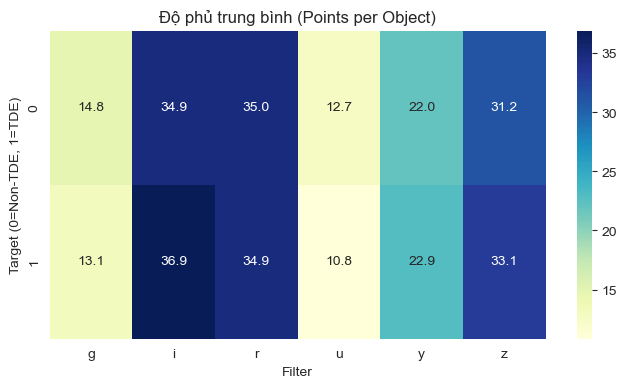

In [79]:
print("\n=== 6. DATA QUALITY CHECK (COVERAGE) ===")

# Đếm số lượng điểm dữ liệu cho mỗi filter theo từng class
coverage = lc_merged.groupby(['target', 'Filter']).size().unstack(fill_value=0)

# Chia cho số lượng object để ra trung bình
obj_counts = lc_merged.groupby('target')['object_id'].nunique()
coverage_avg = coverage.div(obj_counts, axis=0)

print("Trung bình số điểm ảnh (Observations) mỗi Filter:")
print(coverage_avg)

plt.figure(figsize=(8, 4))
sns.heatmap(coverage_avg, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Độ phủ trung bình (Points per Object)')
plt.ylabel('Target (0=Non-TDE, 1=TDE)')
plt.show()

In [80]:
summary = {
    "n_objects": lc_sample.object_id.nunique(),
    "median_n_obs": obs_per_obj.median(),
    "median_duration": dur.median(),
    "median_snr": lc_sample["SNR"].median()
}

summary

{'n_objects': 170,
 'median_n_obs': 148.0,
 'median_duration': 1135.7436500000003,
 'median_snr': 0.7356875158724464}

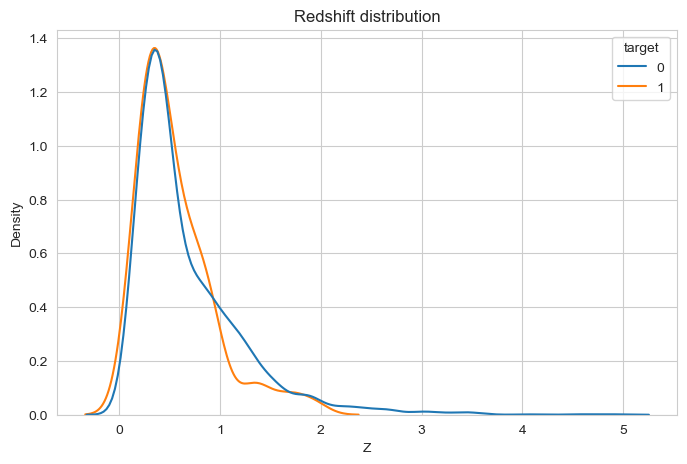

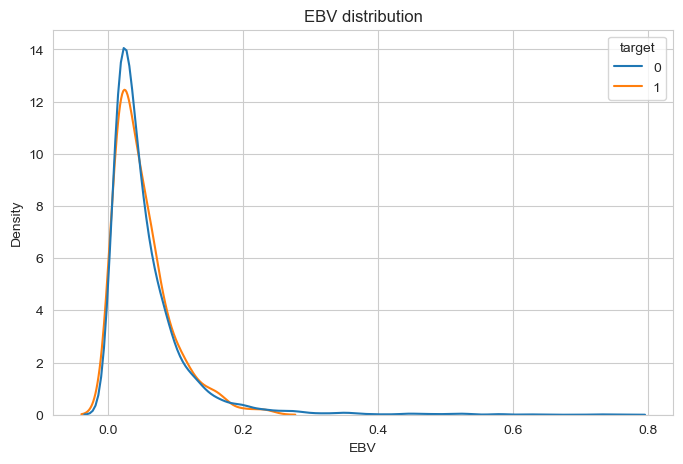

In [82]:
plt.figure(figsize=(8,5))
sns.kdeplot(train_log, x="Z", hue="target", common_norm=False)
plt.title("Redshift distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(train_log, x="EBV", hue="target", common_norm=False)
plt.title("EBV distribution")
plt.show()